
# K-Nearest Neighbours Classification



In [5]:
import numpy as np
#%matplotlib notebook
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.core.debugger import set_trace

## Iris Dataset
We conveniently load the dataset from the sklearn collection of datasets

In [6]:
from sklearn import datasets
dataset = datasets.load_iris()
print(dataset.DESCR)

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
                
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
    ============== ==== ==== ======= ===== ===========


Optional visualization
visualization using `pandas`

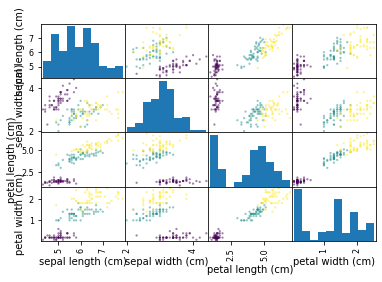

In [7]:
import pandas as pd
from pandas.plotting import scatter_matrix
#creating data frame for pandas
dataframe = pd.DataFrame(dataset['data'], columns=dataset['feature_names'])
#ploting scatter graph of species comparing all features to each other
scatter_matrix(dataframe, c=dataset['target'],marker='o', s=5)
#print(dataframe)
plt.show()

create the input matrix $X \in \mathbb{R}^{N \times D}$ and the output vector $y \in \{1,\ldots,C\}^N$
let's only use `sepal length` and `sepal width` for classification, since we know they have high correlation with the class label. Also, and randomly split the data into train and test and visualize the data.

instances (N) 	 150 
 features (D) 	 2 
 classes (C) 	 3


Text(0.5, 0, 'sepal width')

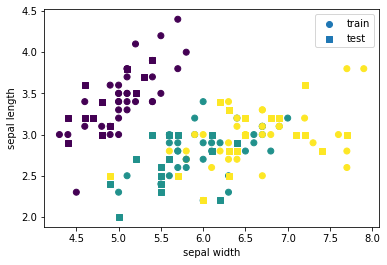

In [8]:
x, y = dataset['data'][:,:2], dataset['target']
(N,D), C = x.shape, np.max(y)+1
print(f'instances (N) \t {N} \n features (D) \t {D} \n classes (C) \t {C}')
inds = np.random.permutation(N)
#train-test split)
x_train, y_train = x[inds[:100]], y[inds[:100]]
x_test, y_test = x[inds[100:]], y[inds[100:]]
#visualization
plt.scatter(x_train[:,0], x_train[:,1], c=y_train, marker='o', label='train')
plt.scatter(x_test[:,0], x_test[:,1], c=y_test, marker='s', label='test')
plt.legend()
plt.ylabel('sepal length')
plt.xlabel('sepal width')

## the `KNN` class


In [30]:
euclidean = lambda x1, x2: np.sqrt(np.sum((x1 - x2)**2, axis=-1))
manhattan = lambda x1, x2: np.sum(np.abs(x1 - x2), axis=-1)

class KNN:
        
    def __init__(self, k=1, metric= "euclidean"):
        if metric.lower() == "euclidean":
            self.metric = euclidean
        elif metric.lower() == "manhattan":
            self.metric = manhattan
        else:
            raise Exception(f'unknown metric: {metric}')
        self.k = k
        return 
    
    def fit(self, x,y):
        self.x = x
        self.y = y
        self.c = np.max(y) + 1
        return self
    
    def predict(self, x_test):
        num_test = x_test.shape[0]
        distances = self.metric(self.x[None,:,:], x_test[:,None,:]) # num_test x num_train
        y_prob = np.zeros((x_test.shape[0], self.c))
        knns = np.zeros((x_test.shape[0], self.k), dtype=int)
        for i in range(num_test):
            knns[i,:] = np.argsort(distances[i])[:self.k]
            y_prob[i,:] = np.bincount(self.y[knns[i,:]], minlength=self.c)
            #stats.mode(self.y[knns[i,:]])[0] # for regression replace with mean or median
        y_prob /= np.sum(y_prob,1,keepdims=True)
        return y_prob, knns

accuracy is 78.0.


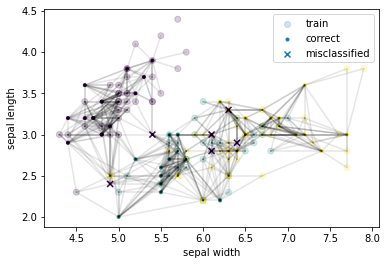

In [60]:
model = KNN(k=15)
y_prob, knns = model.fit(x_train, y_train).predict(x_test)
y_pred = np.argmax(y_prob,1)
accuracy = np.sum(y_pred == y_test)/y_test.shape[0]
print(f'accuracy is {accuracy*100:.1f}.')
#visualization
correct = y_test == y_pred
incorrect = np.logical_not(correct)
plt.scatter(x_train[:,0], x_train[:,1], c=y_train, marker='o', alpha=.2, label='train')
plt.scatter(x_test[correct,0], x_test[correct,1], marker='.', c=y_pred[correct], label='correct')
plt.scatter(x_test[incorrect,0], x_test[incorrect,1], marker='x', c=y_test[incorrect], label='misclassified')

#connect each node to k-nearest neighbours in the training set
for i in range(x_test.shape[0]):
    for k in range(model.k):
        hor = x_test[i,0], x_train[knns[i,k],0]
        ver = x_test[i,1], x_train[knns[i,k],1]
        plt.plot(hor, ver, 'k-', alpha=.1)
    
plt.ylabel('sepal length')
plt.xlabel('sepal width')
plt.legend()

# Decision Boundary

Text(0.5, 0, 'sepal width')

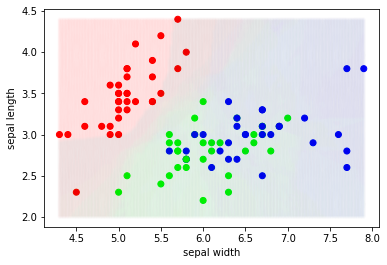

In [57]:
x0v = np.linspace(np.min(x[:,0]), np.max(x[:,0]), 200)
x1v = np.linspace(np.min(x[:,1]), np.max(x[:,1]), 200)
x0,x1 = np.meshgrid(x0v, x1v)
x_all = np.vstack((x0.ravel(),x1.ravel())).T

model = KNN(k=15)
y_train_prob = np.zeros((y_train.shape[0], C))
y_train_prob[np.arange(y_train.shape[0]), y_train] = 1
y_prob_all, _ = model.fit(x_train, y_train).predict(x_all)
plt.scatter(x_train[:,0], x_train[:,1], c=y_train_prob, marker='o', alpha=1)
plt.scatter(x_all[:,0], x_all[:,1], c=y_prob_all, marker='.', alpha=.01)
plt.ylabel('sepal length')
plt.xlabel('sepal width')

## KNN Regression

change the method and add diabetes example